In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits import mplot3d
import pykep
import random
from scipy.optimize import newton
import csv
import pandas as pd
import math
from numpy.linalg import inv
import copy

Utility functions

In [152]:
def check_duplicates(data):
    duplicates = []
    i1 = 0
    for dict1 in data:
        i2 = 0
        for dict2 in data:
            if dict1 == dict2 and i1 != i2 and dict2 not in duplicates:
                duplicates.append(dict2)
            i2 +=1
        i1+=1
    if duplicates:
        return True, duplicates
    else:
        return False, duplicates
    

def check_points(point, data):
    for dict in data:
        if dict["Point"] == point:
            return True
    return False


In [3]:
def normalise_input(series):
    """
    Normalises the pandas dataframe and convert each entry to a np array represting a unit vector.
    Returns the normalised one.
    """
    series = series.str.strip("[ ")
    series = series.str.strip("[")
    series = series.str.strip("]")
    series = series.str.replace('  ',' ')
    for i in range(len(series)):
        series[i] = np.fromstring(series[i], sep=' ')
    return series

In [4]:
def to_global_axis(vector, r, v):
    """
    Calculates the rotation matrix and applies it. Returns the converted vector.
    r and v are used to calculate the rotation matrix and vector is the vector to be 
    rotated.
    """
    unit_r = r/np.linalg.norm(r)
    unit_v = v/np.linalg.norm(v)

    R = np.array([[unit_v[0], -unit_r[0], unit_r[1]*unit_v[2] - unit_v[1]*unit_r[2]],
                [unit_v[1], -unit_r[1], unit_v[0]*unit_r[2] - unit_r[0]*unit_v[2]],
                [unit_v[2], -unit_r[2], unit_r[0]*unit_v[1] - unit_v[0]*unit_r[1]]])

    return R.dot(vector)

In [5]:
def normalise_orbit(orbit):
    i = 0
    for element in orbit:
        if math.isnan(element) is True:
            orbit[i] = False
        i+=1
    return orbit

In [6]:
def to_csv(data, filename):
    for dict1 in data:
        dict1.update({"Rho_i":dict1["Point"][0]})
        dict1.update({"Rho_f":dict1["Point"][1]})
    
    with open(filename, 'w', newline='') as f:
        fieldnames = ["Point", "Orbit", "Fit","Rho_i","Rho_f"]
        writer = csv.DictWriter(f, fieldnames=fieldnames)

        writer.writeheader()
        writer.writerows(data)

In [7]:
def evaluate_D(elementsO, TOF):
    mu = 398600  # km^3/s^2. Make into a global variable later. Can I make TOF a global variable?
    aO = elementsO[0]
    eO = elementsO[1]
    aT_max = 50000

    # some calculations
    rO_perigee = (1-eO)*aO
    vO_perigee = ((1+eO)/(1-eO) * mu/aO)**0.5
    vT_perigee_max = (2*mu/rO_perigee*(1-rO_perigee/(2*aT_max)))**0.5

    return (vO_perigee + vT_perigee_max)*TOF, rO_perigee

In [8]:
def grid_between_lines(D, N, a=9000):
    distances = []  # a list that will contain the whole population points (rho_i, rho_f)
    A = a*a
    A_s = A - (a-D)*a/2 - (a-2*D)*(a-D)/2
    no_of_nodes = N*A/A_s  # no of nodes in the 9000x9000 (height x width) rectangle

    xs = np.linspace(0, a, int((no_of_nodes)**0.5)) # create values for rho_i
    ys = np.linspace(0, a, int((no_of_nodes)**0.5)) # create values for rho_f
    
    for x in xs:
        for y in ys:
            if y < (x + D) and y > (x - D):
                distances.append([x,y])  # only add points that are between the lines

    #plt.plot(xc, yc, '.r')
    #plt.show()
    
    return distances

In [9]:
def get_elite(data, n=100):
    values = []
    for dict1 in data:
        values.append(dict1["Fit"])
        values.sort(reverse=True)  # descending order

    data_elite = []
    min_value = values[n-1]

    for dict2 in data:
        if dict2["Fit"]>= min_value and len(data_elite) < 100:
            data_elite.append(dict2)

    return data_elite

def get_best(data):
    max_fit = 0
    i = 0
    for dict1 in data:
        fit = dict1["Fit"]
        if fit > max_fit:
            i_max = i
            max_fit = fit
        i += 1
    return data[i_max]


In [10]:
def show_pop(data):
    xs = []
    ys = []
    for dict1 in data:
        xs.append(dict1["Point"][0])
        ys.append(dict1["Point"][1])
        
    plt.plot(xs, ys, '.k')
    plt.show()

Orbit as a function of time

In [11]:
def get_period(a, mu = 398600):
    """`
    return the period in seconds
    a needs to be in km
    """
    return (2*np.pi*a**1.5)/mu**0.5

def kepler(E, M_e, e):
    """Kepler's equation, to be used in a Newton solver."""
    return E - e * np.sin(E) - M_e

def d_kepler_d_E(E, M_e, e):
    """The derivative of Kepler's equation, to be used in a Newton solver.
    
    Note that the argument M_e is unused, but must be present so the function
    arguments are consistent with the kepler function.
    """
    return 1 - e * np.cos(E)

def time_since_perigee(elements):
    a = elements[0]
    e = elements[1]
    E = elements[5]
    E_mean = E - e*np.sin(E)
    T = get_period(a)
    return E_mean * T/(2*np.pi)

def propagate_based_on_vector(r,v, t):
    rf, vf = pykep.propagate_lagrangian(r0 = r, v0 = v, tof = t,mu = 398600)
    return np.array(rf), np.array(vf)

def propagate_based_on_elements(elements, t, kepler=True):
    r, v = pykep.par2ic(elements, mu=398600)
    rf,vf = pykep.propagate_lagrangian(r0 = r, v0 = v, tof = t,mu = 398600)
    if kepler == False:  # return vectors
        return np.array(rf),np.array(vf)
    if kepler == True:  # return kepler elements
        return pykep.ic2par(rf,vf,mu = 398600)

Unit vectors

In [12]:
def unit_vector(vector1, vector2):
    """
    returns the unit vector between two vectors.
    """
    rel = vector2 - vector1
    return rel/np.linalg.norm(rel)

def L_between_orbits(elements1, elements2, t, tof):
    """
    Input is two Kepler orbits in Kepler elements
    """
    r1, v1 = propagate_based_on_elements(elements1, t, kepler=False)
    r_ideal,v3 = propagate_based_on_elements([7133.8,0.0043,np.radians(10),np.radians(0),np.radians(0),np.radians(0)], t, kepler=False)
    r2, v2 = propagate_based_on_elements(elements2, tof, kepler=False)
    r1 = np.array(r1)
    r2 = np.array(r2)
    #print("Target pos vector", r2)
    #print("Ideal pos  vector",r_ideal)
    rel = r2 - r1
    #print("relative vec", rel)
    rel_ideal = r_ideal - r1
    #print("ideal rel vec", rel_ideal)
    unit = rel/np.linalg.norm(rel)
    #print("ideal rel unit vec",rel_ideal/np.linalg.norm(rel_ideal))
    return unit

def L_between_orbits_ic(r, elements2,t):
    """
    Used if propagated r has already been found.
    """
    r2, v2 = propagate_based_on_elements(elements2, t, kepler=False)
    r= np.array(r)
    r2 = np.array(r2)
    rel = r2 - r
    unit = rel/np.linalg.norm(rel)
    return unit

Lambert's problem

In [13]:
def constraints(elements, rO_perigee):
    """
    Return true if satisfied.
    """
    a = elements[0]
    e = elements[1]
    R_earth = 6371 # km
    
    if R_earth + 200 <= a and a <= 50000 and 0 <= e and e <= 1 - rO_perigee/50000: # aT_max = 50000 km
        return True
    else:
        return False

In [14]:
def get_target_r(elementsO, rel_initial, rel_final, point, ti,tof):
    """
    The inputs are the observer elements and target posistion vectors as unit vectors in observer CS.
    For final measurments they are propagated forward in time (t).
    Point corresponds to a chromosome.
    Returns intial and final target posistion vectors.
    """
    # initial "measurment" and orbit
    rho_i = point[0]
    rO_initial, vO_initial = propagate_based_on_elements(elementsO, ti, kepler=False)
    L_t0 = to_global_axis(rel_initial,rO_initial, vO_initial)
    rT_i = rho_i*L_t0 + rO_initial
    # final "measurment" and orbit
    rho_f = point[1]
    rO_final, vO_final = propagate_based_on_elements(elementsO, ti+tof, kepler=False)
    L_tf = to_global_axis(rel_final, rO_final, vO_final)
    rT_f = rho_f*L_tf + rO_final
    return rT_i, rT_f

In [15]:
def solve_lambert(ri, rf, t):
    """
    Solves the lambert problem. Input two posistion vector and the time between those locations.
    Returns the solution in Kepler elements.
    """
    # solve Lambert's problem
    l = pykep.lambert_problem(r1 = ri, r2 = rf, tof = t, mu=398600)
    # convert results
    vi = l.get_v1()[0]  # get the velocity vector at initial time for one revolution
    elements = pykep.ic2par(ri,vi, mu=398600)  # get Kepler elements from pos and vel vectors
    return elements

In [16]:
def Lambert_problem(data, elementsO, rT_initial, rT_final, point, rO_perigee, ti, TOF):
    # set up Lambert's problem
    ri, rf = get_target_r(elementsO, rT_initial, rT_final, point, ti,TOF)
    
    # solve Lambert's problem
    elementsT_estimated = list(solve_lambert(ri, rf, t = TOF))
    elementsT_estimated = normalise_orbit(elementsT_estimated)
    if constraints(elementsT_estimated, rO_perigee) is True:
        new_dict = dict(Point = point, Orbit = elementsT_estimated)
        data.append(new_dict)
    if constraints(elementsT_estimated, rO_perigee) is False:
        raise ValueError
    return data

Genetic algorithm building blocks

In [212]:
def mutate(data, elementsO, r_initial, r_final, rO_perigee, ti, TOF, index):
    """
    mutates a single data point given by index. If the point doesn't satisfy conditions then
    the function returns False.
    """
    stnd_devs = [-10,-5,-2,2,10,5] # may change. In the paper they used 10
    added = 0
    for stnd_dev in stnd_devs:
        rho0, rho1 = data[index]["Point"]
        new_point = [rho0 + stnd_dev, rho1 + stnd_dev]
        if check_points(new_point,data) is False:  # not a duplicate
            try:
                data = Lambert_problem(data, elementsO, r_initial, r_final, new_point, rO_perigee, ti, TOF)
                added += 1
            except ValueError:
                continue 
    if added > 0:
        return True, data
    else:
        return False, data

def mutation(data, elementsO, r_initial, r_final, rO_perigee, ti, TOF, no_of_outputs):
    """
    Input how many extra chromoses are wanted.
    """
    indices = [x for x in range(len(data))]
    
    last_length = len(data)
    final_length = last_length + no_of_outputs
    
    while len(data) != final_length:
        if len(data) < final_length:
            passed = False
            while passed is False:
                index = random.choice(indices)  # get a random entry from list
                indices.remove(index)  # remove that entry to avoid duplicates
                passed, data = mutate(data, elementsO, r_initial, r_final, rO_perigee, ti, TOF, index)  
                if passed == True:
                    no_of_successful_mutations = len(data) - last_length 
                    #print("at", no_of_successful_mutations, "duplictes", check_duplicates(data))
                if not indices:  # list is empty
                    #print("no of successful mutations", no_of_successful_mutations)
                    indices = [x + last_length for x in range(no_of_successful_mutations)]  # mutate the mutated points further
                    
                    last_length = len(data)
           
        if len(data) > final_length:
            no_of_extra_points = len(data) - final_length 
            
            for i in range(no_of_extra_points):
                index = random.randint(0, len(data)-1)
                
                data.pop(index)
            
        
    return data

In [259]:
def one_crossover(point1, point2, data, D):
    if np.random.randint(0,2) == 1:
        #print("first point1",point1)
        #print("first point2",point2)
        point1[1] = point2[1]
        #print("second point1",point1)
        #print("second point2",point2)
        if abs(point1[0] - point1[1]) < D and abs(point2[0] - point2[1]) < D:
            #print("passed up")
            return point1
        else:
            return False
    else:
        point2[1] = point1[1]
        if abs(point1[0] - point1[1]) < D and abs(point2[0] - point2[1]) < D:
            #print("passed down")
            return point2
        else:
            return False

def get_random_points(data):
    index1 = random.randint(0, len(data) - 1)
    index2 = random.randint(0, len(data) - 1)
    while index1 == index2:  # can't be the same
        index2 = random.randint(0, len(data) - 1)
    point1 = data[index1]["Point"]
    point2 = data[index2]["Point"]
    return point1, point2

def crossover(data, elementsO, r_initial, r_final, rO_perigee, ti, TOF, no_of_outputs, D):
    for i in range(no_of_outputs):
        passed = False
        while passed is False:
            point1, point2 = get_random_points(data)
            extra_point = one_crossover(point1, point2, data,D)
            while extra_point == False:
                point1, point2 = get_random_points(data)
                extra_point = one_crossover(point1, point2, data,D)  # the inequality must be satisfied
            try:
                data = Lambert_problem(data, elementsO, r_initial, r_final, extra_point, rO_perigee, ti, TOF)  # solve for orbits
                passed = True
            except ValueError:
                passed = False  # will go back into the loop and select a new random point that passes the constraints
    return data


In [19]:
def fitness(elementsO, set_of_measurments, estimated_orbit):
    fit = 1
    t_initial = set_of_measurments[0][-1]
    #print("initial time", t_initial)
    for coordinates in set_of_measurments:
        t = coordinates[-1]
        #print("time", t)
        r,v = propagate_based_on_elements(elementsO, t, kepler=False)
        #print("pos vector of sat", r,v)
        #print("measured unit vector in body CS", coordinates)
        L_measurment = to_global_axis(coordinates[:-1],r,v)
        tof = t - t_initial
        L_ast = L_between_orbits(elementsO, estimated_orbit,t,tof)
        #print("L ast", L_ast)
        #print("measured unit vector in global CS", L_measurment)
        fit = fit * np.dot(L_measurment, L_ast)
    return fit

def objective_func(elementsO, set_of_measurments, data):
    for og_dict in data:
        #print("orbit", og_dict["Orbit"])
        fit_value = fitness(elementsO, set_of_measurments, og_dict["Orbit"])
        og_dict["Fit"] = fit_value   # fitness value in the data
    return data


In [214]:
def initialise_pop(elementsO, rel_intial, rel_final, ti, TOF=60, N=1000):
    """
    Initialises the population of specific size based on initial and final "measurments".
    The inputs are the observer orbit and the inital and final posistion vector for the target.
    Returns a list of dictionaries.
    """
    D, rO_perigee = evaluate_D(elementsO, TOF)
    
    # get an evenly spaced grid between two lines Rho in the range [0,9000]
    original_population = grid_between_lines(D, 5*N)  # initial population
    data = []
    
    for point in original_population:
        try:
            data = Lambert_problem(data, elementsO, rel_intial, rel_final, point, rO_perigee, ti, TOF)
        except ValueError:
            continue
    
    n = len(data)
    if n > N:
        # remove the number of extra points randomly
        no_of_extra_points = n - N
        for i in range(no_of_extra_points):
            index = random.randint(0, len(data)-1)
            data.pop(index)

    if n < N:
        # gain extra points via mutation
        no_of_extra_points = N - n
        #print(no_of_extra_points)
        data = mutation(data, elementsO, rel_intial, rel_final, rO_perigee, ti, TOF, no_of_extra_points)  
        
    return data

Stop conditions

In [21]:
def mean(data):
    n = len(data)
    sum_i = 0
    sum_f = 0
    for dict1 in data:
        sum_i += dict1["Point"][0]
        sum_f += dict1["Point"][1]
    return sum_i/n, sum_f/n    

def covariance_matrix(data):
    """
    Returns the standard deviations of the population in terms of two variables.
    Our points consist of initial and final distance.
    """
    c11 = 0
    c12 = 0
    c22 = 0
    mean_i, mean_f = mean(data)
    n = len(data)
    for dict1 in data:
        c11 += (dict1["Point"][0]-mean_i)**2
        c12 += (dict1["Point"][0]-mean_i)*(dict1["Point"][1]-mean_f)
        c22 += (dict1["Point"][1]-mean_f)**2
    return (c11/n)**0.5, (c22/n)**0.5, (c12/n)**0.5

def last_similarity(List, error = 0):
    """
    The input list should be a list (2x2) in a list of length phi.
    Return true if all the elements in the list are similar (same) comapred to the last element.
    """
    value1, value2 = List[-1]
    for point in List:
        last_value1, last_value2 = point
        difference1 = abs(last_value1 - value1)
        difference2 = abs(last_value2 - value2)
        if difference1 <= error and difference2 <= error:
            continue
        else:
            return False   # is not similar
    return True  # is similar
    
def stop_criteria(data, last_means, last_best_values, no_of_gens,lim_O = 5, lim_F = 5, max_gen=30,error = 0):
    """
    Returns True if met.
    """
    # for means
    means_sim = last_similarity(last_means)
    # for best values
    best_sim = last_similarity(last_best_values)
    # standard values
    sigma_OO, sigma_FF, sigma_OF = covariance_matrix(data)
    #print("standard dev", sigma_OO, sigma_FF, sigma_OF)
    
    if means_sim == True:
        print("similarity in means")
        return True
    if best_sim == True:
        print("similarity in last best")
        return True
    if no_of_gens >= max_gen:
        print("max gens")
        return True, None, None
    if sigma_OO <= lim_O and sigma_FF <= lim_F:
        print("stnd dev")
        return True
    else:
        return False  # need these values for the next iteration

Initialisation

In [22]:
elements_sat = [7350,0.0,np.radians(0),np.radians(0),np.radians(0),np.radians(0)]
elements_deb = [7133.8,0.0043,np.radians(10),np.radians(0),np.radians(0),np.radians(0)]

In [36]:
%store -r line

In [38]:
set_of_measurments = line[15:]

In [216]:
set_of_measurments = new_test

In [92]:
# measurments from detecting objects
data_meas = pd.read_csv('data/measurments.csv')
set_of_measurments = data_meas.loc[1]  #choose which line to check
set_of_measurments = normalise_input(set_of_measurments.dropna())

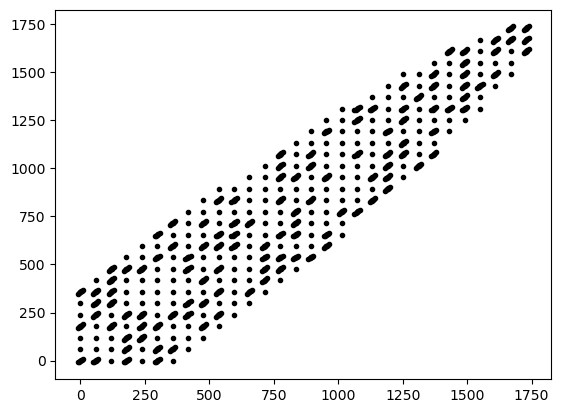

1000


In [261]:
r1 = set_of_measurments[0][:-1]
r2 = set_of_measurments[-1][:-1]
tof = set_of_measurments[-1][-1] - set_of_measurments[0][-1]
ti = set_of_measurments[0][-1]
# initialise
data = initialise_pop(elements_sat, r1, r2, ti, TOF=tof)
show_pop(data)
print(len(data))

In [262]:
data = objective_func(elements_sat, set_of_measurments, data)

In [226]:
check_duplicates(data)

(False, [])

In [263]:
data_elite = get_elite(data)

In [264]:
data_test = copy.deepcopy(data_elite)

In [265]:
best_point = get_best(data)["Point"]
no_of_gens = 0
phi = 3
print("best point", best_point)
last_means = [(0,0) for x in range(phi)]
last_means.pop(0)
last_means.append(mean(data))

last_best_values = [(0,0) for x in range(phi)]
last_best_values.pop(0)
last_best_values.append(best_point)

D, rO_perigee = evaluate_D(elements_sat, tof)  # maybe there is a better way to define this

best point [784.8344370860926, 844.4370860927152]


Body

In [260]:
data_crossover = crossover(data_test, elements_sat, r1,r2, rO_perigee, ti, tof, 50, D)

In [266]:
while stop_criteria(data, last_means, last_best_values, no_of_gens) is False:
    #print("iteration", no_of_gens)
    data_elite = get_elite(data)
    
    # create new population and corresponding orbits
    data_created = initialise_pop(elements_sat, r1, r2, ti, TOF=tof, N=50)  # create 5% of desired population size
    
    data_elite = data_elite + data_created
    
    #mutate
    data_mutation = mutation(data_elite, elements_sat, r1,r2, rO_perigee, ti, tof, 800)  # 800 corresponds to 80% of desired population 
    #print("mutation", check_duplicates(data_mutation))
    # crossover
    data_crossover = crossover(data_mutation, elements_sat, r1,r2, rO_perigee, ti, tof, 50, D)  # crossover 5% of desired population size
    data = data_crossover
    #print("final", len(data))
    print("crossover", check_duplicates(data_crossover))
    # get new fit_values
    data = objective_func(elements_sat, set_of_measurments, data)
    
    # update last_means, last_best_values, no_of_gens
    last_means.pop(0)
    last_means.append(mean(data))
    #print("last means", last_means)
    best_point = get_best(data)["Point"]
    #print("the best", best_point)
    last_best_values.pop(0)
    last_best_values.append(best_point)
    #print("last bests", last_best_values)
    no_of_gens += 1
else:
    print("donzo")

crossover (False, [])
crossover (False, [])
crossover (True, [{'Point': [798.1818181818182, 1070.909090909091], 'Orbit': [17233.018057933146, 0.6724400911605704, 0.6333791509194745, 0.00397503963498121, 0.873183178340004, -0.39892002752642947]}])
crossover (True, [{'Point': [1102.909090909091, 830.1818181818182], 'Orbit': [13769.488963556303, 0.7255607480263406, 0.4497434695224846, 6.272310162327286, 4.803855361343627, 0.7189098061761846]}])
crossover (True, [{'Point': [797.4370860927152, 826.1818181818182], 'Orbit': [7988.927260266718, 0.189679795870236, 0.49314621197040864, 6.282381038300042, 5.904987594022357, 0.33025595502129856]}])
crossover (False, [])
similarity in last best
donzo


In [267]:
best_ones = []

In [268]:
best = get_best(data)
best_ones.append(best)
best_ones

[{'Point': [758.8344370860926, 815.4370860927152],
  'Orbit': [8064.82227688633,
   0.18244891108742053,
   0.49167991164058183,
   6.283175901914152,
   6.270454289838908,
   0.026587205181777505],
  'Fit': 0.9999999974282786}]

Debug

In [152]:
data = [{"point":2}, {"point":2}]

In [153]:
check_duplicates(data)

(True, [{'point': 2}])

In [44]:
set_of_measurments = data_meas.loc[0]  #choose which line to check
set_of_measurments = normalise_input(set_of_measurments.dropna())

In [24]:
%store -r line

In [23]:
%store -r B_CS

In [42]:
test = line

In [24]:
test = B_CS
new_test = []
for t in range(len(B_CS)):
    new_test.append(np.append(B_CS[t],[t]))
new_test = new_test[15:]

In [160]:
ri,vi = propagate_based_on_elements(elements_deb, 15, kepler=False)
rf, vf = propagate_based_on_elements(elements_deb, 20, kepler=False)
print(rf)
t = 5
l = pykep.lambert_problem(r1 = ri, r2 = rf, tof = t, mu=398600)
# convert results
vi = l.get_v1()[0]  # get the velocity vector at initial time for one revolution
elements = pykep.ic2par(ri,vi, mu=398600)  # get Kepler elements from pos and vel vectors
propagate_based_on_elements(elements,-5,kepler=False)

[7101.54467811  147.85122      26.07015922]


(array([7102.72965339,   73.92972254,   13.03580476]),
 array([-0.07900058,  7.39269804,  1.30353212]))

In [99]:
to_global_axis([0.01673061, 0.99673921, 0.07893691],r,v)

array([-0.99687808,  0.00174933,  0.07893691])

In [159]:
ri,vi = propagate_based_on_elements(elements_deb, 10, kepler=False)
ri

array([7102.7296534 ,   73.92972125,   13.03580453])

In [132]:
r,v = pykep.par2ic([8245.657560540574,
   0.20534029174864293,
   0.5135931240644889,
   6.2831747413631085,
   6.2700191398409,
   0.026614868377443087], mu=398600)
r

(6551.83252777798, 111.85786606524107, 63.136458873548825)

In [202]:
fitness(elements_sat, new_test, [8245.6575605406,0.2053402917,0.5135931241,6.2831747414,6.2700191398,0.0266148684])

pos vector of sat [7349.16994482  110.45868981    0.        ] [-0.11067194  7.36335822  0.        ]
Target pos vector [6551.83252818  111.85786623   63.13645883]
Ideal pos  vector [7102.23590559  110.89201231   19.55325372]
relative vec [-797.33741664    1.39917642   63.13645883]
ideal rel vec [-246.93403923    0.43332251   19.55325372]
ideal rel unit vec [-0.99687808  0.00174933  0.07893691]
L ast [-0.99687808  0.00174933  0.07893691]
measured unit vector in global CS [-0.99687808  0.00174933  0.07893691]
pos vector of sat [7349.05558411  117.82199135    0.        ] [-0.11804946  7.36324364  0.        ]
Target pos vector [6551.7078605   119.31463141   67.34271184]
Ideal pos  vector [7102.11345792  118.28413341   20.85668411]
relative vec [-797.34772361    1.49264006   67.34271184]
ideal rel vec [-246.94212619    0.46214206   20.85668411]
ideal rel unit vec [-0.99645051  0.00186482  0.08416002]
L ast [-0.99645062  0.00186536  0.08415862]
measured unit vector in global CS [-0.99645051  

0.9999999969924491

In [200]:
fits=[]
for i in range(len(data_meas)):
    set_of_measurments = data_meas.loc[i]  #choose which line to check
    set_of_measurments = normalise_input(set_of_measurments.dropna())
    fit = fitness(elements_sat, new_test, [7133.8,0.0043,np.radians(10),np.radians(0),np.radians(0),0.015785194118121015])
    fits.append(fit)

pos vector of sat [7349.16994482  110.45868981    0.        ] [-0.11067194  7.36335822  0.        ]
Target pos vector [7102.23590559  110.89201231   19.55325372]
Ideal pos  vector [7102.23590559  110.89201231   19.55325372]
relative vec [-246.93403923    0.43332251   19.55325372]
ideal rel vec [-246.93403923    0.43332251   19.55325372]
ideal rel unit vec [-0.99687808  0.00174933  0.07893691]
L ast [-0.99687808  0.00174933  0.07893691]
measured unit vector in global CS [-0.99687808  0.00174933  0.07893691]
pos vector of sat [7349.05558411  117.82199135    0.        ] [-0.11804946  7.36324364  0.        ]
Target pos vector [7102.11345792  118.28413341   20.85668411]
Ideal pos  vector [7102.11345792  118.28413341   20.85668411]
relative vec [-246.94212619    0.46214206   20.85668411]
ideal rel vec [-246.94212619    0.46214206   20.85668411]
ideal rel unit vec [-0.99645051  0.00186482  0.08416002]
L ast [-0.99645051  0.00186482  0.08416002]
measured unit vector in global CS [-0.99645051  

In [201]:
max(fits)

0.9999999999999986

In [146]:
v = [0,1,0]
r = [1,0,0]
vec = [0,1,0]
to_global_axis(vec,r,v)

array([-1.,  0.,  0.])

In [147]:
print(best_point)

D, rO_perigee = evaluate_D(elements_sat, 60)
# Set up Lambert's problem
rT_i, rT_f = get_target_r(elements_sat,elements_deb, [4686.363636363637, 4686.363636363637], 60)
# solve Lambert's problem
elementsT_estimated = list(solve_lambert(r1 = rT_i, r2 = rT_f, tof = 60))
print(elementsT_estimated)
fit = fitness(elements_sat, elements_deb, elementsT_estimated, no_of_measurments = 60)
print(fit)

[1019.3239436619718, 639.0422535211268]


TypeError: get_target_r() missing 1 required positional argument: 't'

In [262]:
print("from rho",propagate_based_on_elements([6929.3203653797,0.0300116531,1.7162873512,0.8762504074,5.7380713477,3.1008175552], 0, kepler=False))
print("ideal", propagate_based_on_elements(elements_deb, 0, kepler=False))

print("satellite", propagate_based_on_elements(elements_sat,0, kepler=False))

print(unit_vector(propagate_based_on_elements(elements_sat,0, kepler=False)[0], propagate_based_on_elements([6929.3203653797,0.0300116531,1.7162873512,0.8762504074,5.7380713477,3.1008175552], 0, kepler=False)[0]))

print(unit_vector(propagate_based_on_elements(elements_sat,0, kepler=False)[0], propagate_based_on_elements(elements_deb, 0, kepler=False)[0]))

from rho (array([-3370.40082161, -4938.35873329,  3897.60440158]), array([-3.28804323, -2.55804492, -6.06789951]))
ideal (array([ 2644.71527012, -6597.70363665,   203.65960376]), array([6.1781863 , 2.13873564, 3.83254291]))
satellite (array([-3407.72971403, -4928.06109229,  3920.52845889]), array([-3.34761025, -2.58520094, -6.12964399]))
[ 0.82953094 -0.22883647 -0.50942349]
[ 0.82953093 -0.22883647 -0.5094235 ]


In [ ]:
fit = fitness(elements_sat, elements_deb, [9450.49625553981, 0.2501664703342994, 1.7154666684924387, 0.8703258847995052, 2.9719140826855535, -2.995440490696146], no_of_measurments = 60)
fit

Python reminder

In [115]:
L = random.choice([1,3,6,2,4])
L


1

In [113]:
f = False
n = 0
while f == False:
    n +=1
    if n == 3:
        print("here")
        f = False
        break
    print(n)

1
2
here


In [79]:
l = [x for x in range(3)]
l

[0, 1, 2]

In [ ]:
l = [{"brand": "Ford",
  "model": "Mustang",
  "year": 1964
}, {
  "brand": "Volvo",
  "model": "SUV",
  "year": 2018
},
{"brand": "Audi",
  "model": "A7",
  "year": 2013},
  ]

for dict1 in l:
    if dict1["year"] >= 2000:
        dict1["new"] = True

# order l based on year
years = []
for dict1 in l:
    years.append(dict1["year"])
    years.sort()

years

[1964, 2013, 2018]

In [ ]:
e1 = [9450.49625553981, 0.2501664703342994, 1.7154666684924387, 0.8703258847995052, 2.9719140826855535, -2.995440490696146]
r, v = pykep.par2ic(e1, mu=398600)
rf,vf = pykep.propagate_lagrangian(r0 = r, v0 = v, tof = 50,mu = 398600)
e2 = pykep.ic2par(rf,vf,mu = 398600)
e2

(9450.496255539807,
 0.25016647033429984,
 1.7154666684924387,
 0.8703258847995052,
 2.971914082685554,
 -2.9678853860378602)

In [ ]:
np.radians(180)

3.141592653589793

In [47]:
for t in range(2):
    print(t)

0
1
